In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from random import sample, seed
from tqdm import tqdm_notebook
from sklearn.datasets import load_boston, load_breast_cancer
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error

In [228]:
def load_spam():
    train = np.loadtxt('dataset/spam.train.txt')
    test  = np.loadtxt('dataset/spam.test.txt')
    X_train = train[:, 1:]
    y_train = train[:, 0].astype('int')
    X_train, y_train = shuffle_data(X_train, y_train, seed=1)
    X_test = test[:, 1:]
    y_test = test[:, 0].astype('int')
    X_test, y_test = shuffle_data(X_test, y_test, seed=1)
    return X_train, X_test, y_train, y_test

In [209]:
def shuffle_data(X, y, seed=None):
    if seed:
        np.random.seed(seed)
    idx = np.arange(X.shape[0])
    np.random.shuffle(idx)
    return X[idx], y[idx]

def loss(y, p):
    return np.mean(- y * np.log(p) - (1 - y) * np.log(1 - p))

def plot_compare(sklearn_model, my_model, X_train, y_train, X_test, y_test):
    if sklearn_model:
        plt.figure(figsize=(15, 5))
        sklearn_model_train = sklearn_model.train_score_
        sklearn_model_test = [sklearn_model.loss_(y_test, y_pred) for y_pred in sklearn_model.staged_decision_function(X_test)]
        plt.plot(range(len(sklearn_model_train)), sklearn_model_train, label='sklearn train')
        plt.plot(range(len(sklearn_model_test)), sklearn_model_test, label='sklearn test')

        # train_staged = [sklearn_model.loss_(y_train, y_pred) for y_pred in sklearn_model.staged_decision_function(X_train)]
        # test_staged = [y_pred[:,1] for y_pred in sklearn_model.staged_predict_proba(X_test)]
        # test_staged = [loss(y_test, y_pred)*2 for y_pred in test_staged]
        # plt.plot(range(len(train_staged)), train_staged)
        # plt.plot(range(len(test_staged)), test_staged)
        
        plus_three = sklearn_model_test[-1] * 1.03
        print("Sklearn Loss: ", np.round(sklearn_model_test[-1], 3))
        print("threshold 3%: ", np.round(plus_three, 3))
        # plt.plot([0, len(sklearn_model_test)], [plus_three, plus_three])

    if my_model:
        my_model_train = [loss(y_train, y_pred)*2 for y_pred in my_model.train_pred_]
        my_model_test = [loss(y_test, y_pred)*2 for y_pred in my_model.predict(X_test, all_trees=True)]
        plt.plot(range(len(my_model_train)), my_model_train, label='my train')
        plt.plot(range(len(my_model_test)), my_model_test, label='my test')
        
        print("My Loss: ", np.round(my_model_test[-1], 3))

    plt.legend()
    plt.xlabel("Count tree")
    plt.ylabel("Loss")
    plt.grid()
    plt.show()

### CART

In [210]:
class Node:
    def __init__(self, left=None, right=None, column_idx=None, split_predicate=None):
        self.left = left
        self.right = right
        self.column_idx = column_idx
        self.split_predicate = split_predicate
        self.is_leaf = False
        self.samples_in_leaf = []
        
    def __str__(self):
        return f"column_idx: {self.column_idx}, split_predicate: {self.split_predicate}, answer: {np.mean(self.samples_in_leaf)}"
    
class CART():
    def __init__(self, max_depth=None, min_samples_leaf=1):
        self.max_depth = max_depth
        self.min_samples_leaf=min_samples_leaf
        
        self.cur_depth_ = 0
        
    def _variance(self, y):
        return np.mean(np.power(y - y.mean(), 2))
        
    def _information_gain(self, X, y, i):
        left_size = (i + 1) / len(X)
        right_size = (len(X) - i - 1) / len(X)
        return left_size * self._variance(y[:i+1]) + right_size * self._variance(y[i+1:])
    
    # Лучшее разбиение вершины
    def _split_tree(self, X, y, information_gain):  
        features_count = X.shape[1]
        column_idx = None
        split_predicate = None
        
        # Ищем такой признак и предикат при котором критерий информативности будет минимальный
        for col in range(features_count):
            Xy = np.array(sorted(np.hstack((X[:, col].reshape(-1, 1), y.reshape(-1, 1))), key=lambda x: x[0]))
            X_cur = Xy[:, 0]
            y_cur = Xy[:, -1]
            
            for i in range(len(X_cur) - 1):                
                if X_cur[i] == X_cur[i + 1]: continue
                information_gain_new = self._information_gain(X_cur, y_cur, i)
                
                if information_gain_new < information_gain:
                    information_gain = information_gain_new
                    split_predicate = X_cur[i]
                    column_idx = col          
        
        # Делим на правую у левую ветку по предикату
        df = pd.DataFrame(np.hstack((X, y.reshape(-1, 1))))
        df_left = df[df[column_idx] <= split_predicate]
        df_right = df[df[column_idx] > split_predicate]
        
        return column_idx, split_predicate, \
               df_left.iloc[:, :-1].values, df_left.iloc[:, -1].values, \
               df_right.iloc[:, :-1].values, df_right.iloc[:, -1].values
            
    # Построение дерева
    def _build_tree(self, X, y, cur_depth):
        root = Node()
        
        # Критерий информативности в текущей вершине
        information_gain = self._variance(y)
        
        # Делаем вершину листом
        if len(y) == self.min_samples_leaf or cur_depth == self.max_depth:
            root.is_leaf = True
            root.samples_in_leaf = y
            return root
        
        cur_depth = cur_depth + 1
        if cur_depth > self.cur_depth_:
            self.cur_depth_ = cur_depth
        
        # Делим дальше
        column_idx, split_predicate, X_left, y_left, X_right, y_right = self._split_tree(X, y, information_gain) 
        root.left = self._build_tree(X_left, y_left, cur_depth)
        root.right = self._build_tree(X_right, y_right, cur_depth)
        root.column_idx = column_idx
        root.split_predicate = split_predicate
            
        return root
    
    def _get_answer(self, root, row):
        if root.is_leaf:
            return root.samples_in_leaf
        root = root.left if row[root.column_idx] <= root.split_predicate else root.right
        return self._get_answer(root, row)
    
    def predict(self, X, mean_leaf=True):
        if mean_leaf:
            return np.array([self._get_answer(self.root, row).mean() for row in X])
        else:
            return np.array([self._get_answer(self.root, row) for row in X])
    
    def fit(self, X, y):
        self.root = self._build_tree(X, y, self.cur_depth_)
        return self

In [211]:
X = load_boston().data
y = load_boston().target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=17)
depth = 2

In [212]:
%%time
my_tree = CART(max_depth=depth).fit(X_train, y_train)
y_pred_my = my_tree.predict(X_test)
print("my_tree", mean_squared_error(y_test, y_pred_my))

my_tree 27.520300327953436
CPU times: user 227 ms, sys: 5.47 ms, total: 233 ms
Wall time: 234 ms


In [213]:
%%time
proper_tree = DecisionTreeRegressor(max_depth=depth, random_state=0).fit(X_train, y_train)
y_pred = proper_tree.predict(X_test)
print("proper_tree", mean_squared_error(y_test, y_pred))

proper_tree 27.52030032795343
CPU times: user 2.04 ms, sys: 1.97 ms, total: 4.01 ms
Wall time: 2.41 ms


### GradientBoostingClassifier

In [214]:
class GradientBoosting():
    def __init__(self, n_estimators=100, learning_rate=0.1, max_depth=2, f_interaction=False):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.f_interaction = f_interaction
        
        self.base_algorithms = []
        self.weights = []
        self.y_pred = None
        self.cur_depth_ = 1 if self.f_interaction else self.max_depth
        self.train_pred_ = []
        
    def _sigmoid(self, h):
        return 1 / (1 + np.exp(-h))
    
    def _get_class(self, p):
        return np.where(p < 0.5, 0, 1)
        
    def _loss(self, y, p):
        return np.mean(- y * np.log(p) - (1 - y) * np.log(1 - p))

    def _gradient(self, y, y_pred):
        # - y*log(sigma(x)) - (1-y)*log(1-sigma(x))
        # sigma(x)' = sigma(x) * (1 - sigma(x))
        # dL/dx = - y*sigma*(1-sigma)/sigma + (1-y)(1-sigma)/sigma*(1-sigma) = sigma(x) - y
        return self._sigmoid(y_pred) - y
    
    def _newton(self, y, a, h):
        # sigma(x) = 1 / (1 + exp(-(h+b*a)))
        # dx/db = (h+b*a)' = a
        # f = dL/db = a * (sigma(x) - y)
        # f' = (a * (sigma(x) - y))' = a * sigma(x)' * (h+b*a)' = a * sigma*(1-sigma) * a = a^2 * sigma*(1-sigma)
        b = 0
        while True:
            z = h + b * a
            f = np.sum(a * (self._sigmoid(z) - y))
            dfdb = np.sum(np.power(a, 2) * self._sigmoid(z) * (1 - self._sigmoid(z)))
            b = b - f / dfdb
            if np.abs(f) < 0.0005: break
        return b
    
    def predict(self, X, all_trees=False):
        predicts = []
        predict = np.zeros(len(X))
        for i, base_algorithms in enumerate(self.base_algorithms):
            predict = predict + self.learning_rate * base_algorithms.predict(X) * self.weights[i]
            predicts.append(self._sigmoid(predict))
        if all_trees:
            return predicts
        else:
            return self._get_class(predicts[-1])
    
    def fit(self, X, y):
        self.y_pred = np.zeros(len(y))

        for i in tqdm_notebook(range(self.n_estimators), total=self.n_estimators, mininterval=1):             
            gradient = - self._gradient(y, self.y_pred)

            tree = CART(max_depth=self.cur_depth_).fit(X, gradient)
            # tree = DecisionTreeRegressor(max_depth=self.cur_depth_, random_state=17).fit(X, gradient)
            self.base_algorithms.append(tree)
            y_pred = tree.predict(X)
            
            weights = self._newton(y, y_pred, self.y_pred)
            self.weights.append(weights)
            
            self.y_pred = self.y_pred + self.learning_rate * y_pred * weights
            self.train_pred_.append(self._sigmoid(self.y_pred))
            
#             if self.f_interaction and i > 1:
#                 if self._loss(y, self.train_pred_[-1]) == self._loss(y, self.train_pred_[-2]):
#                     if self.cur_depth_ < self.max_depth:
#                         self.cur_depth_ += 1
        
        return self

A Jupyter Widget

Sklearn Loss:  0.262
threshold 3%:  0.27
My Loss:  0.302


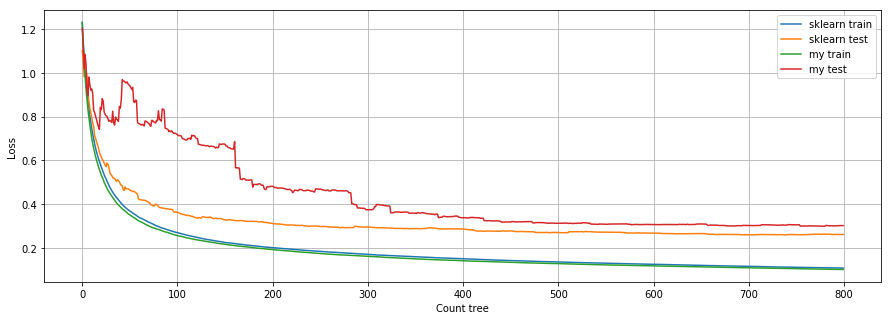

CPU times: user 10h 5min 15s, sys: 2min 57s, total: 10h 8min 12s
Wall time: 10h 18min 45s


In [227]:
%%time
# Мой бустинг и мое дерево
X_train, X_test, y_train, y_test = load_spam()

n = 800
lr = 0.2
depth = 1

clrBoost = GradientBoostingClassifier(n_estimators=n, learning_rate=lr, max_depth=depth, random_state=17)
clrBoost.fit(X_train, y_train)

clrBoost_my = GradientBoosting(n_estimators=n, learning_rate=lr, max_depth=depth)
clrBoost_my.fit(X_train, y_train)

plot_compare(clrBoost, clrBoost_my, X_train, y_train, X_test, y_test)

A Jupyter Widget

Sklearn Loss:  0.199
threshold 3%:  0.205
My Loss:  0.201


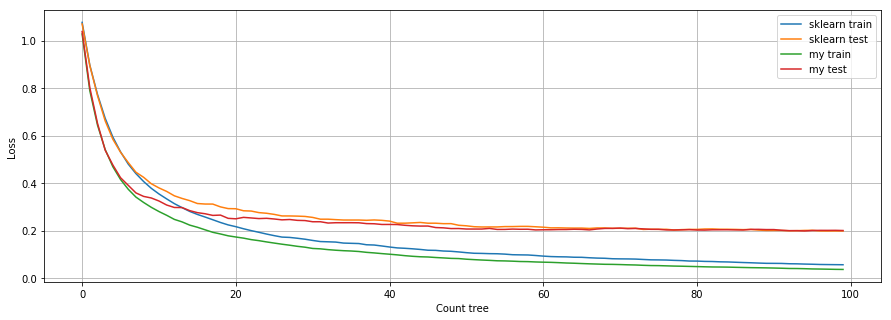

CPU times: user 54.3 s, sys: 970 ms, total: 55.3 s
Wall time: 57.4 s


In [222]:
%%time
# Мой бустинг и дерево sklearn
X = load_breast_cancer().data
y = load_breast_cancer().target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=17)

n = 100
lr = 0.2
depth = 1

clrBoost = GradientBoostingClassifier(n_estimators=n, learning_rate=lr, max_depth=depth, random_state=17)
clrBoost.fit(X_train, y_train)

clrBoost_my = GradientBoosting(n_estimators=n, learning_rate=lr, max_depth=depth)
clrBoost_my.fit(X_train, y_train)

plot_compare(clrBoost, clrBoost_my, X_train, y_train, X_test, y_test)